In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib.cm as cm
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
import array
%matplotlib inline
sys.path.append('..')
from zwatershed import *
from visualization.visualize_funcs import *
from edgelist_methods import *
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'
from multiprocessing import Pool
import nyroglancer


# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# -------------------------------- load data ---------------------------------------
f = h5py.File(pred_file, 'r')
preds = np.array(f['main']).astype('float32')
g = h5py.File(gt_seg,'r')
gt_seg = g['main']
print preds.shape

(3, 432, 432, 432)


# Divide Volumes, set up args

In [11]:
def dim_to_name(start):
    return str(start[0])+'_'+str(start[1])+'_'+str(start[2])+'_vll/'
dims = np.array(preds.shape[1:])
print "dims",dims # x,y,z
num_vols = np.array([int(x/MAX_LEN)+1 for x in dims])
# num_vols[0] = 2 # delete this!
deltas = dims/num_vols
print "num_vols",num_vols
print "deltas",deltas
starts,ends = [],[]
for x in range(num_vols[0]):
    for y in range(num_vols[1]):
        for z in range(num_vols[2]):
            starts.append((x,y,z)*deltas - [3,3,3] +3*np.array([x==0,y==0,z==0]))
            extra = 3*np.array([x==num_vols[0]-1,y==num_vols[1]-1,z==num_vols[2]-1],dtype='int')
            ends.append((x,y,z)*deltas + deltas + [1,1,1]+extra +[3,3,3])
args = []
for i in range(len(starts)):
    s,e = starts[i],ends[i]
    pred_vol = preds[:,s[0]:e[0],s[1]:e[1],s[2]:e[2]]
    print i,s,e,pred_vol.shape
    args.append((pred_vol,out_folder+dim_to_name(s)))    

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]
0 [0 0 0] [148 148 148] (3, 148, 148, 148)
1 [  0   0 141] [148 148 292] (3, 148, 148, 151)
2 [  0   0 285] [148 148 439] (3, 148, 148, 147)
3 [  0 141   0] [148 292 148] (3, 148, 151, 148)
4 [  0 141 141] [148 292 292] (3, 148, 151, 151)
5 [  0 141 285] [148 292 439] (3, 148, 151, 147)
6 [  0 285   0] [148 439 148] (3, 148, 147, 148)
7 [  0 285 141] [148 439 292] (3, 148, 147, 151)
8 [  0 285 285] [148 439 439] (3, 148, 147, 147)
9 [141   0   0] [292 148 148] (3, 151, 148, 148)
10 [141   0 141] [292 148 292] (3, 151, 148, 151)
11 [141   0 285] [292 148 439] (3, 151, 148, 147)
12 [141 141   0] [292 292 148] (3, 151, 151, 148)
13 [141 141 141] [292 292 292] (3, 151, 151, 151)
14 [141 141 285] [292 292 439] (3, 151, 151, 147)
15 [141 285   0] [292 439 148] (3, 151, 147, 148)
16 [141 285 141] [292 439 292] (3, 151, 147, 151)
17 [141 285 285] [292 439 439] (3, 151, 147, 147)
18 [285   0   0] [439 148 148] (3, 147, 148, 148)
19 [285  

# Call Watershed

In [ ]:
def zwshed_h5_par(arg):
    (pred_vol,seg_save_path) = arg
    zwatershed_basic_h5(pred_vol,seg_save_path)
    print "finished",seg_save_path,"watershed"
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)
# zwshed_h5_par(args[0])

# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
	filter merges...
	merging numbers, 183 keys ... 
	before nsegs= 26638 num0= 74275701
	after nsegs= 26604 num0= 74275701


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


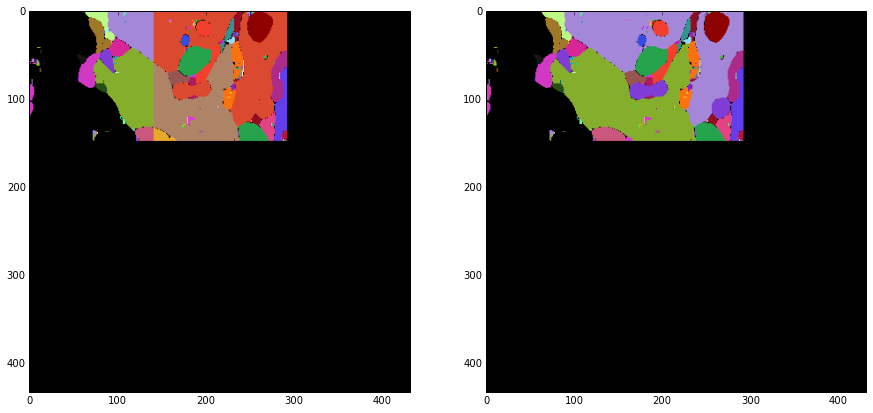

merging rgs...
	renumbering all... 26604 num0= 74275701


/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:87: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


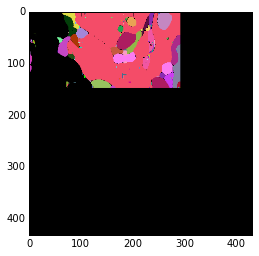

finishedd


In [24]:
# todo - have this support several threshes - for filename in os.listdir(arg[2]):
filename = 'basic.h5'
seg_out = np.zeros(dims,dtype='uint64')
rgs = {}
re,merges={},{}
X,Y,Z = (1,1,2)
merges = {}
for x in range(X): #num_vols[0]):
    for y in range(Y): #num_vols[1]):        
        for z in range(Z): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            basic_file = h5py.File(arg[1]+filename,'r')
            seg = np.array(basic_file['seg'])
            rg = np.array(basic_file['rg'])
            inc = np.max(seg_out)+1
            seg[seg!=0]+=inc
            rg[:,:2] += inc
            rgs[i] = rg
            print "i,x,y,z",i,x,y,z
            if not z==0: 
                re,merges = calc_merges(edge_mins=seg_out[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, merges=merges)
            if not y==0:
                re,merges = calc_merges(edge_mins=seg_out[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,merges=merges)
            if not x==0:
                re,merges = calc_merges(edge_mins=seg_out[s[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, merges=merges)
            seg_out[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]
            
merges_filtered = filter_merges(merges)            
seg_out,rgs = merge(merges_filtered,seg_out,rgs,p=True)
seg_out,rgs = renum_all(seg_out,rgs,p=True)

# calculate sizes
seg_ids,seg_sizes = np.unique(seg_out,return_counts=True)
# sizes = np.arra
# sizes[seg_ids] = seg_sizes
    
print "finished"
# display_seg_xy(seg_out)

In [23]:
# stitch methods
COUNT_THRESH = 0
def calc_merges(edge_mins,edge_maxes, re, merges={}):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,merges)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,merges)
    return re, merges  

def add_or_inc(key_max,key_min,d):
    key = (key_max,key_min)
    if not key in d:
        d[key] = 1
    else:
        d[key] +=1

def filter_merges(merges):
    print "\tfilter merges..."
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in merges:
        count = merges[pair]
        e1,e2 = pair
        if e1 in count_maxes:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
    
    # compress merges
    sum_counts = 0
    for key in merges:
        sum_counts += merges[key]
    renums_filtered = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if merges[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums_filtered[key] = val
    return renums_filtered
    
def merge(renums_filtered,seg,rgs,p=False):     
    # merge segs
    print "\tbefore nsegs=",len(np.unique(seg)),"num0=",np.sum(seg==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(seg[0, :, :], cmap=cmap)
    mp = np.arange(0,np.max(seg)+1,dtype='uint64')
    mp[renums_filtered.keys()] = renums_filtered.values()
    seg = mp[seg]
    print "\tafter nsegs=",len(np.unique(seg)),"num0=",np.sum(seg==0)
    if p:
        plt.subplot(1,2,2)
        plt.imshow(seg[0, :, :], cmap=cmap)
    plt.show()
    
    # merge rgs
    print "\tmerging rgs..."
    for key in rgs:
        rg = rgs[key]
        rg_to_renum = rg[:,:2].astype('int')
        rg[:,:2] = mp[rg_to_renum]
        rgs[key] = rg
    return seg,rgs

def renum_all(seg,rgs,p=False):    
    
    segId = np.unique(seg)
    renum = np.zeros(segId.max()+1,dtype=np.uint64)
    renum[segId] = np.arange(1,len(segId)+1)
    renum[0]=0
    seg = renum[seg]

    print "\trenumbering all...",len(np.unique(seg)),"num0=",np.sum(seg==0)
    if p:
        plt.imshow(seg[0, :, :], cmap=cmap)
    plt.show()

    return seg, rgs

# Visualize

In [25]:
def display_affs(raw):
    plt.imshow(np.transpose(raw[:, :, :, 1],(2,1,0)))
    plt.show()
def display_seg_yz(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(raw[depth, :, :], cmap=cmap)
    plt.show()
def display_seg_xy(raw,depth=1):
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0.2, bottom=0.25)
    ax1.imshow(raw[:, :, depth], cmap=cmap)
    plt.show()

In [ ]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.arange(1,10)
x2 = np.delete(x,1,0)
y2 = np.delete(y,5)
print x
print x2
print y
print y2

In [22]:
mp = np.arange(0,np.max(seg_out)+1,dtype='uint64')
print mp.size
print len(rgs)
for i in range(len(rgs)):
    if i in rgs:
        rg = rgs[i]
        rg_to_renum = rg[:,:2].astype('int')
        rg[:,:2] = mp[rg_to_renum]
        rgs[i] = rg

# rg_[:,:2] = mp[rg_[:,:,2]]

26605
2


IndexError: index 26994 is out of bounds for axis 1 with size 26605

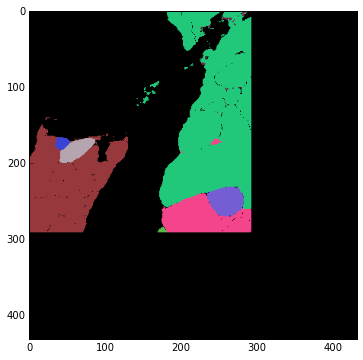

In [26]:
display_seg_xy(seg_out)

In [13]:
v = nyroglancer.Viewer()
v.set_hostname("localhost:8888")
v.put(gt_seg, resolution=[1,1,1], vtype="segmentation", name="raw")
v.show()

In [20]:
x = np.array([[1,2,3],[4,5,6]])
y = np.zeros(x.shape)
y[:,1]=1
print x
print y
print 

[[1 2 3]
 [4 5 6]]
[[ 0.  1.  0.]
 [ 0.  1.  0.]]
